# BEFORE EXECUTING ANY CELL IN THIS NOTEBOOK, RUN THIS CODE TO INSTALL ALL NECESSARY LIBRARIES AND PACKAGES!

In [3]:
#1

!pip install geopy
!pip install geopandas contextily --quiet

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
import ipywidgets as widgets

import os
import glob
import re
import joblib

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectFromModel
from sklearn.cluster import KMeans
from sklearn.inspection import PartialDependenceDisplay

from scipy.interpolate import griddata

from shapely.geometry import Point

from matplotlib.colors import ListedColormap, BoundaryNorm

from IPython.display import display, clear_output

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 57.4 MB/s eta 0:00:00


# **Preparation of the dataset**

## Cleaning

In the cell below, the starting dataset is cleaned from entries missing ID, location and end date.

In [59]:
#2

#UPLOAD: database_permessi.csv

permit_data = pd.read_csv("/content/database_permessi.csv", delimiter=";", dtype={'RICHIESTA N° PROT': str})
# Remove rows where the "closure date" column is NaN or empty
permit_data_clean = permit_data.dropna(subset=['CHIUSURA PRATICA DATA'])  # If values are NaN
permit_data_clean = permit_data_clean[(permit_data_clean['CHIUSURA PRATICA DATA'] != "") ]  # If values are empty strings

# Rinomina la prima colonna di permit_data_clean
first_col_name = permit_data_clean.columns[0]  # Nome della prima colonna
permit_data_clean.rename(columns={first_col_name: "ID_RICHIESTA"}, inplace=True)
permit_data_clean['ID_RICHIESTA'] = permit_data_clean['ID_RICHIESTA'].astype(int)
# Print the number of rows before and after cleaning
print(f"Rows before cleaning: {len(permit_data)}")
print(f"Rows after cleaning: {len(permit_data_clean)}")
#print(permit_data_clean)
permit_data_clean.describe(include='all')

Rows before cleaning: 1715
Rows after cleaning: 1596


,ID_RICHIESTA,RICHIESTA ANNO PROT,RICHIESTA DATA,PROCEDIMENTO,ESITO PRATICA,CHIUSURA PRATICA DATA,CODICE VIA,CIVICO,ESPONENTE CIVICO,LOCALIZZAZIONI LISTA
count,1596.000000,1596.000000,1596,1596,1596,1596,1537.000000,1284.000000,247,1544
unique,NaN,NaN,1220,21,46,1153,NaN,NaN,39,1264
top,NaN,NaN,2008-07-25,permesso di costruire,Rilasciata con prescrizioni,2008-12-18,NaN,NaN,2,VIALE CARLO BERTI PICHAT N. 2 / 4
freq,NaN,NaN,7,480,613,9,NaN,NaN,84,11
mean,222062.736842,2014.374687,NaN,NaN,NaN,NaN,31386.180872,37.877726,NaN,NaN
std,162521.006555,5.192950,NaN,NaN,NaN,NaN,18804.141081,59.068423,NaN,NaN
min,39.000000,2008.000000,NaN,NaN,NaN,NaN,70.000000,0.000000,NaN,NaN
25%,97844.000000,2009.000000,NaN,NaN,NaN,NaN,16650.000000,6.000000,NaN,NaN
50%,190254.500000,2014.000000,NaN,NaN,NaN,NaN,29880.000000,16.000000,NaN,NaN
75%,298241.250000,2019.000000,NaN,NaN,NaN,NaN,50500.000000,42.000000,NaN,NaN


N.B. the columns "CODICE VIA" and "CIVICO" were kept as they were for further refinement after cross-referencing with intervention datasets

The following cell prepares the excels containing building and intervention descriptions, gathering them all in one csv with the same columns.

In [60]:
#3

# CREATE a folder named "excel_folder"
# UPLOAD the contents of the correspondent folder in the repository in the notebook

# Path to the folder containing the Excel files
path = "/content/excel_folder"  # Modify with the correct path
all_files = glob.glob(os.path.join(path, "*.xls*"))
df_list=[]
for file in all_files:
    # Extracts the file name without the path
    file_name = os.path.basename(file)
    # Loads the dataset
    df = pd.read_excel(file)
    # Adds a column with the file name
    df['NOMI_FILE'] = file_name

    # Renames specific columns
    df.rename(columns={
        'RICHIESTA N° PROT': 'ID_RICHIESTA',
        'N. Protocollo':'ID_RICHIESTA',
        'RICHIESTA_N°_PROT':'ID_RICHIESTA',
        'Oggetto': 'DESCRIZIONE_RICHIESTA',
        'OGGETTO': 'DESCRIZIONE_RICHIESTA',
        'Indirizzo': 'LOCALIZZAZIONE_RICHIESTA',
        'LOCALIZZAZIONI LISTA': 'LOCALIZZAZIONE_RICHIESTA',
        'LOCALIZZAZIONI_LISTA': 'LOCALIZZAZIONE_RICHIESTA',
        'Anno': 'ANNO',
        'RICHIESTA ANNO PROT': 'ANNO',
        'RICHIESTA_ANNO_PROT': 'ANNO'
    }, inplace=True)

    # Filters to keep only the desired columns
    columns_to_keep = ['ID_RICHIESTA', 'DESCRIZIONE_RICHIESTA', 'LOCALIZZAZIONE_RICHIESTA', 'ANNO','NOMI_FILE']
    df = df[[col for col in columns_to_keep if col in df.columns]]

    # Keeps only rows where ID_RICHIESTA is not empty
    df = df.dropna(subset=['ID_RICHIESTA'])
    df['ID_RICHIESTA'] = df['ID_RICHIESTA'].astype(int)
    df_list.append(df)

# Merges all Excel files into a single DataFrame
df_excel = pd.concat(df_list, ignore_index=True)

# Removes any duplicate columns with slightly different names
df_excel = df_excel.loc[:, ~df_excel.columns.duplicated()]

# Final check
print(df_excel.describe(include="all"))  # General statistics
#print(df_excel)
df_excel.to_csv('new_df_excel.csv', index=False)


        ID_RICHIESTA                              DESCRIZIONE_RICHIESTA  \
count   1.111000e+03                                               1111   
unique           NaN                                               1102   
top              NaN  PERMESSO DI COSTRUIRE - NON RESIDENZIALE per i...   
freq             NaN                                                  2   
mean    2.265239e+05                                                NaN   
std     3.290383e+05                                                NaN   
min     1.147000e+03                                                NaN   
25%     1.055355e+05                                                NaN   
50%     1.921720e+05                                                NaN   
75%     2.946070e+05                                                NaN   
max     9.999999e+06                                                NaN   

                  LOCALIZZAZIONE_RICHIESTA         ANNO             NOMI_FILE  
count              

Finally, the following cell merges the starting database and the information in the excels to gather all necessary data regarding building permits in Bologna. The merging is based on the correspondence of the REQUEST_ID to avoid ambiguities.

In [61]:
#4

permit_data_clean = permit_data_clean.drop_duplicates(subset=['ID_RICHIESTA'])
df_excel = df_excel.drop_duplicates(subset=['ID_RICHIESTA'])

# "Inner" merge to keep only the rows common to both permit_data_clean and df_excel
df_merged = permit_data_clean.merge(df_excel, on="ID_RICHIESTA", how="inner")

# Removes duplicates based on the "ID_RICHIESTA" column
df_merged = df_merged.drop_duplicates(subset=['ID_RICHIESTA'])

# Create permit_data_senzacorrispondenza (rows from permit_data_clean without a match in df_excel)
df_senzacorrispondenza = permit_data_clean.merge(df_excel, on="ID_RICHIESTA", how="left", indicator=True)
df_senzacorrispondenza = df_senzacorrispondenza[df_senzacorrispondenza['_merge'] == 'left_only'].drop(columns=['_merge'])

# Check that the total number of rows matches permit_data_clean
n_originali = len(permit_data_clean)
n_merged = len(df_merged)
n_senza_corrispondenza = len(df_senzacorrispondenza)

# Save the datasets
df_merged.to_csv('df_merged.csv', index=False)


## Categorisation of the entries

The following code classifies the outcomes and end use of the building based on a key word search to create a pattern. In this cell the variables "REQUEST_TIME", "OUTCOME", "WITH_CONDITIONS", "DEST_XX" are created.

In [62]:
# 5

file_path = '/content/df_merged.csv'
df = pd.read_csv(file_path, sep=None, engine='python', parse_dates=['RICHIESTA DATA', 'CHIUSURA PRATICA DATA'])

# Calculate duration of the practice in days
df['DURATA_PRATICA'] = (df['CHIUSURA PRATICA DATA'] - df['RICHIESTA DATA']).dt.days

# Outcome classification
esiti_map = {
    'positivi': ['Efficace', 'Rilasciata', 'Rilasciata con prescrizioni'],
    'negativi': ['Negata', 'Archiviata', 'Decaduta', 'Annullata', 'Rinuncia'],
    'neutri': ['Conclusa', 'Sospesa', 'Variante']
}

def classify_esito(esito):
    if not isinstance(esito, str):
        return 'Neutro'
    esito = esito.strip()
    for category, values in esiti_map.items():
        if esito in values:
            return category.capitalize()[:-1]  # Removes the final 'i'
    return 'Neutro'

df['RICHIESTA_DATA'] = df['RICHIESTA DATA']
df['ESITO_RICHIESTA'] = df['ESITO PRATICA'].apply(classify_esito)
df['CON_PRESCRIZIONI'] = df['ESITO PRATICA'].apply(lambda x: 1 if isinstance(x, str) and 'con prescrizioni' in x.lower() else 0)

# Definition of use destinations and pattern
destinazioni = {
    'Residenziale': {'codice': 1, 'pattern': r'\b(U1|1a|1b|a1|residenz|allogg|studentat|abita|casa|case|socio assistenziale|immobiliar|vill|appart|centro anziani|familiar|abitativ|unifamiliar|bifamiliar|trifamiliar|sottotetto|condomin|civile\s+abitaz)\w*\b'},
    'Ufficio': {'codice': 2, 'pattern': r'\b(uffic|direzional|terziario|convegn|consolato|congress|3a|3b)\w*\b'},
    'Commerciale': {'codice': 3, 'pattern': r'\b(U6|U7|U8|4c|4d|5c|commerc|negoz|edicola|gomme|chiosc|mercato|self storage|store|officina|centro commerciale|vendita|rivendita|esposizione|tipografia|autolavaggi|rifornimento|carburant|retail|eserciz[io]?\s+commerc)\w*\b'},
    'Albergo': {'codice': 4, 'pattern': r'\b(U14|U15|alberg|campegg|hotel|ricreativ|ricettiv|ospitalit|turist|b&b|residence|rta)\w*\b'},
    'Industriale e produttiva': {'codice': 5, 'pattern': r'\b(2a|2b|2B|industr|industriale|deposit|magazzin|capannon|artigian|agricol|produttiv|laborator|stabilimento|portineria|container)\w*\b'},
    'Sociali, ricreative, culturali e religiose': {'codice': 6, 'pattern': r'\b(chies|orator|parroc|espositiv|religi|scommesse|S. Maria|polifunzionale|Pepoli|convent|culto|U2|scienz|ristor|bar|sala slot|VLT|biblio|fieristic|fashion|avventura|padiglione 37)\w*\b'},
    'Sanitario': {'codice': 7, 'pattern': r'\b(U5|U 7a|ospedale|clinica|ricovero|ambulanz|cure|ambulatori|S. Orsola|avis|ambulatorio|sanitario|socio-sanitaria|disabili|terapeutico|struttura sanitaria|diagnostica|patologie)\w*\b'},
    'Istruzione': {'codice': 8, 'pattern': r'\b(U3|7c|scuola|università|istituto scolastico|educativo|liceo|scolastic|asilo)\w*\b'},
    'Sportivo': {'codice': 9, 'pattern': r'\b(U4|maneggio|palestra|spogliatoio|centro sportivo|campo sportivo|impianto sportivo|sport)\w*\b'},
    'Opere_Urbane': {'codice': 10, 'pattern': r'\b(urban|fermata|strad|marciapied|parchegg|area giochi|viabil|urbanizz|parcheggio|garage|autorimess|autorimessa|fognatur|reti\s+tecnologic|piazz|pista per moto|opere esterne)\w*\b'},
    'Impianti': {'codice': 11, 'pattern': r'\b(U12|cabin|impiant|montalettighe|central|fotovoltaic|cella|elettr|telefon|vasca|ascensore|cellulare|gas)\w*\b'}
}

# Apply the patterns for use destinations
for dest_name, dest_info in destinazioni.items():
    col_name = f'DEST_{dest_name}'

    def match_destinazione(x):
        if not isinstance(x, str):
            return 0
        x_lower = x.lower()
        # Special case: exclude only "Residenziale" if "non residenziale" is present
        if dest_name == 'Residenziale' and 'non residenziale' in x_lower:
            return 0
        # Apply the pattern normally
        if re.search(dest_info['pattern'], x, re.IGNORECASE):
            return 1
        return 0

    df[col_name] = df['DESCRIZIONE_RICHIESTA'].apply(match_destinazione)

# Count the number of use destinations for each intervention
df['NUM_DESTINAZIONI'] = df[[f'DEST_{dest}' for dest in destinazioni.keys()]].sum(axis=1)

# Create "Altro" column
df['DEST_Altro'] = df['NUM_DESTINAZIONI'].apply(lambda x: 1 if x == 0 else 0)

# Identify requests "in sanatoria"
df['IN_SANATORIA'] = df['DESCRIZIONE_RICHIESTA'].apply(lambda x: 1 if isinstance(x, str) and 'sanatoria' in x.lower() else 0)

# Select final columns
dest_columns = [f'DEST_{dest}' for dest in destinazioni.keys()] + ['DEST_Altro']
output_columns = [
    'ID_RICHIESTA', 'DURATA_PRATICA', 'RICHIESTA_DATA',  'ESITO_RICHIESTA', 'CON_PRESCRIZIONI',
    *dest_columns,
    'NUM_DESTINAZIONI', 'IN_SANATORIA'
]

new_df = df[output_columns]

# Save the new dataset
output_path = "/content/processed_permit_data.csv"
new_df.to_csv(output_path, index=False)

print(f"Processed dataset saved to: {output_path}")
print(f"Number of rows: {len(new_df)}")
print(f"Requests with multiple destinations: {(new_df['NUM_DESTINAZIONI'] > 1).sum()}")
print(f"Requests in sanatoria: {df['IN_SANATORIA'].sum()}")

for category in destinazioni.keys():
    count = new_df[f'DEST_{category}'].sum()
    perc = count / len(new_df) * 100
    print(f"{category}: {count} ({perc:.2f}%)")

print(f"Altro: {new_df['DEST_Altro'].sum()} ({new_df['DEST_Altro'].sum() / len(new_df) * 100:.2f}%)")


Processed dataset saved to: /content/processed_permit_data.csv
Number of rows: 1063
Requests with multiple destinations: 281
Requests in sanatoria: 121
Residenziale: 383 (36.03%)
Ufficio: 82 (7.71%)
Commerciale: 119 (11.19%)
Albergo: 22 (2.07%)
Industriale e produttiva: 192 (18.06%)
Sociali, ricreative, culturali e religiose: 75 (7.06%)
Sanitario: 32 (3.01%)
Istruzione: 14 (1.32%)
Sportivo: 8 (0.75%)
Opere_Urbane: 208 (19.57%)
Impianti: 136 (12.79%)
Altro: 137 (12.89%)


Following the same logic as above, the segment below creates one-hot variables to map the type of intervention for each entry, creating the variables "INTERVENTION_XX".

In [63]:
# 6
# File paths
file_processed = "/content/processed_permit_data.csv"
file_merged = "/content/df_merged.csv"

# Load the processed CSV (without the description)
df_processed = pd.read_csv(file_processed)

# Load the original CSV to recover the DESCRIZIONE_RICHIESTA column
df_merged = pd.read_csv(file_merged, usecols=["ID_RICHIESTA", "DESCRIZIONE_RICHIESTA"])

# Merge the data on the ID field
df = df_processed.merge(df_merged, on="ID_RICHIESTA", how="left")

# Define pattern for type of intervention
interventi = {
    'Realizzazione opere ex-novo': r'\b(per realizzare|realizzazione|creazione|REALIZZAZIONE|N.C.|NC|N[\W_]*\.?[\W_]*C\.?|nuov|nuova costruzione|costruzione|nuova edificazione|urbanizzazione|completamento)\w*\b',
    'Ampliamento': r'\b(con aumento di volume|un aumento di volume|per lieve variazione della sagoma|per aumento|aumento di volume in altezza|modifica alla sagoma|ampliament|ampiament|estension|soprelevazione|sopraelevazione|annession|espansion|modifica volumetrica)\w*\b',
    'Demolizione': r'\b(demolizion|abbattiment|demolire)\w*\b',
    'Ricostruzione': r'\b(ricostruzion|ricostruire|sostituzione edilizia)\w*\b',
    'Ristrutturazione': r'\b(modific|riconfigurazione|migliorie|variazioni estetiche|RE2|ispessimento|ristrutturazion|ristutturazion|rinnovament|restaur|recupero|riqualificazion|ripristino|manutenzione|miglioramento sismico|adeguamento|regolamentazione|adeguamento volumetrico|regolarizzazione|risanamento)\w*\b',
    'Installazione': r'\b(installazione|montaggi|assemblaggi|posa in opera|inserimento)\w*\b',
    'Cambio Uso':  r'\b(insediamento|mutamento|cambio|C.D.|cd)\w*\b',
    'Variante a progetto':  r'\b(variante|vp|v[\W_]*c[\W_]*o[\W_]*\.?|vco|vcd)\w*\b'
}

# Create columns for each type of intervention
for tipo, pattern in interventi.items():
    col_name = f'INTERVENTO_{tipo.replace(" ", "_")}'
    df[col_name] = df['DESCRIZIONE_RICHIESTA'].apply(lambda x: 1 if isinstance(x, str) and re.search(pattern, x, re.IGNORECASE) else 0)

# Count the number of rows with no match
no_match_count = df[[f'INTERVENTO_{tipo.replace(" ", "_")}' for tipo in interventi.keys()]].sum(axis=1).eq(0).sum()
print(f"Number of rows with no match: {no_match_count}")

# After creating all the intervention columns, calculate 'Altro'
df['INTERVENTO_Altro'] = df[[f'INTERVENTO_{tipo.replace(" ", "_")}' for tipo in interventi.keys()]].sum(axis=1).eq(0).astype(int)

# Remove the DESCRIZIONE_RICHIESTA column to keep the final file lightweight
df.drop(columns=['DESCRIZIONE_RICHIESTA'], inplace=True)

# Save the updated dataset
df.to_csv(file_processed, index=False)

# Print percentages for each category
for category in interventi.keys():
    col_name = f'INTERVENTO_{category.replace(" ", "_")}'
    count = df[col_name].sum()
    perc = count / len(df) * 100
    print(f"{category}: {count} ({perc:.2f}%)")

# Print the percentage and count for the "Altro" category
altro_perc = df['INTERVENTO_Altro'].sum() / len(df) * 100
print(f"Altro: {df['INTERVENTO_Altro'].sum() / len(df) * 100:.2f}% | Number of 'Altro': {df['INTERVENTO_Altro'].sum()}")


Number of rows with no match: 33
Realizzazione opere ex-novo: 665 (62.56%)
Ampliamento: 256 (24.08%)
Demolizione: 221 (20.79%)
Ricostruzione: 143 (13.45%)
Ristrutturazione: 264 (24.84%)
Installazione: 42 (3.95%)
Cambio Uso: 110 (10.35%)
Variante a progetto: 240 (22.58%)
Altro: 3.10% | Number of 'Altro': 33


Lastly, the following cell classifies, using one-hot encoding, each entry according to the entity of the intervention, creating the variables "ENTITY_XX".

In [64]:
# 7

# File paths
file_processed = "/content/processed_permit_data.csv"
file_merged = "/content/df_merged.csv"

# Load data
df_processed = pd.read_csv(file_processed)
df_merged = pd.read_csv(file_merged, usecols=["ID_RICHIESTA", "DESCRIZIONE_RICHIESTA"])
df = df_processed.merge(df_merged, on="ID_RICHIESTA", how="left")

# Remove any old entity columns
entita_cols = [col for col in df.columns if col.startswith("ENTITA_")]
df.drop(columns=entita_cols, errors="ignore", inplace=True)

# Classification based on keywords
def classify_entita(descrizione):
    if not isinstance(descrizione, str):
        return "Altro"

    descrizione = descrizione.lower()

    parole_grande = [
        "nuova costruzion\w*", "costruzione", "edificazione", "nuovo edificio",
        "completamento", "sostituzione edilizia", "nuova edificazione", "opera nuova",
        "opere di urbanizzazione", "creazione", "nuovo fabbricato", "demolizione", "nc", "n.c.",
        "capannone", "realizzazione di un fabbricato", "realizzazione di un edificio", "7 piani",
        "centro commerciale", "realizzazione di un edificio", "centro residenziale",
        "multipiano", "pluripiano", "realizzazione di edificio", "realizzare un edificio",
        "realizzazione edilizia", "realizzazione di edilizia", "realizzazione di torre",
        "padiglione espositivo", "realizzazione di tre edifici", "nuovo organismo edilizio",
        "realizzazione di un organismo edilizio", "microarea familiare"
    ]

    parole_medio = [
        "ampliament", "sopraelevazione", "soprelevazione", "estensione", "ricostruzione", "ampiament",
        "modifica volumetrica", "annessione", "espansione", "modifica alla sagoma", "ispessimento",
        "variazione della sagoma", "ristrutturazione", "restauro", "recupero", "riqualificazione",
        "manutenzione straordinaria", "tetto", "copertura", "distribuzione", "impiant", "aumento",
        "vasca di laminazione","palo", "telefonia", "centrale", "deposito", "autorimessa interrata",
        "autorimess", "garage", "urbanizzazione primaria", "ripostiglio", "mutamento", "campo scuola",
        "interrat", "modifiche di sagoma", "cambio d'uso"
    ]

    parole_piccolo = [
        "installazione", "tettoia", "pensilina", "totem", "chiosco", "insegna", "montaggio",
        "adeguamento", "ripristino", "modifica", "sistemazione", "posa", "arredi", "opere interne",
        "interventi minori", "opere leggere", "serramenti", "infissi", "cabina", "spostament",
        "chiusura", "variazioni distributive", "bussol", "box", "distributore", "bagno prefabbricato",
        "urbanizzazione secondaria", "padiglione di accesso", "area giochi", "copri scopri", "adeguament",
        "potenziamento", "parcheggi", "accesso carrabile", "viabilit", "modifiche interne", "cartongesso",
        "realizzazione scala"
    ]

    for p in parole_grande:
        if p in descrizione:
            return "Grande"
    for p in parole_medio:
        if p in descrizione:
            return "Medio"
    for p in parole_piccolo:
        if p in descrizione:
            return "Piccolo"
    return "Altro"

# Apply classification
df["ENTITA_CATEGORIA"] = df["DESCRIZIONE_RICHIESTA"].apply(classify_entita)

# One-hot encoding to 0/1 (integers)
entita_dummies = pd.get_dummies(df["ENTITA_CATEGORIA"], prefix="ENTITA").astype(int)
df = pd.concat([df, entita_dummies], axis=1)

# Remove temporary column
df.drop(columns=["ENTITA_CATEGORIA", "DESCRIZIONE_RICHIESTA"], inplace=True)

# Final save
df.to_csv(file_processed, index=False)

# Diagnostics
print("\nEntity category distribution:")
for categoria in ["ENTITA_Grande", "ENTITA_Medio", "ENTITA_Piccolo", "ENTITA_Altro"]:
    count = df.get(categoria, pd.Series()).sum()
    perc = count / len(df) * 100 if len(df) > 0 else 0
    print(f"{categoria}: {count} ({perc:.2f}%)")



Entity category distribution:
ENTITA_Grande: 639 (60.11%)
ENTITA_Medio: 321 (30.20%)
ENTITA_Piccolo: 69 (6.49%)
ENTITA_Altro: 34 (3.20%)


## Georeferencing entries

To extract the coordinates of each entry, they were georeferenced based on the address. The code is hereby proposed as a demonstration of the process however the runtime is about two hours so we provided a version of the dataset with the coordinates included to upload and use below.

In [ ]:
#8

# # 1. File upload
# df = pd.read_csv('/content/df_merged.csv')

# # 2. Cleaning of addresses
# def pulisci_indirizzo(addr):
#     if pd.isnull(addr):
#         return ""
#     addr = addr.upper()
#     pattern = r"(CIVICO DA DEFINIRE|INTERO\s*\w+|INTERNO\s*\w+|SCALA\s*\w+|PIANO\s*\w+|SNC|S\.N\.C\.|SUB\s*\w+|SUBALTERN[OAI]\s\w+|EDIFICIO\s*\w+|FABBRICATO\s*\w+|LOTTO\s*\w+|NUMERO\s*\w+)"
#     addr = re.sub(pattern, '', addr)
#     # Rimuovi solo 'N.' o 'N ' se seguiti da un numero (civico)
#     addr = re.sub(r'\bN\.?\s+(?=\d)', '', addr)
#     addr = re.sub(r'\s+', ' ', addr).strip()
#     if "BOLOGNA" not in addr:
#         addr += ", Bologna"
#     return addr.title()

# df['indirizzo_pulito'] = df['LOCALIZZAZIONE_RICHIESTA'].apply(pulisci_indirizzo)


# # 3. Initialise geocoder
# geolocator = Nominatim(user_agent="my_geocoder")
# geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# # 4. Geocoding function with fallback
# def geocode_fallback(address):
#     location = geocode(address)
#     if location:
#         return pd.Series([location.latitude, location.longitude])
#     via = address.split(",")[0]
#     city = "Bologna"
#     location = geocode(f"{via}, {city}")
#     if location:
#         return pd.Series([location.latitude, location.longitude])
#     return pd.Series([None, None])

# # 5. Apply geocoding function to the whole database
# df[['lat', 'lon']] = df['indirizzo_pulito'].apply(geocode_fallback)

# # 6. Count and saves rows with no match
# not_found = df[df['lat'].isnull() | df['lon'].isnull()]
# print(f"Righe senza coordinate trovate: {len(not_found)}")

# # 7. Saves the ID of the rows with no match
# not_found[['ID_RICHIESTA', 'LOCALIZZAZIONE_RICHIESTA', 'NOMI_FILE']].to_csv('/content/indirizzi_non_geocodificati.csv', index=False)

# # 8. (Optional) Save the geocoded rows in a new dataset
# df.to_csv('/content/df_merged_geocoded.csv', index=False)

With the data gathered from QGIS it was possible to extract a list of the buildings located in restricted areas of historical significance or hydrogeological risk. The following code adds this information to the dataset.

In [71]:
#9

# UPLOAD: df_merged_geocoded.csv
#         restrictions_historical.csv
#         restrictions_hydro.csv

# Load CSV files
processed_permit_data = pd.read_csv('processed_permit_data.csv')
edificivincolati = pd.read_csv('restrictions_historical.csv')
edificirischioidrogeo = pd.read_csv('restrictions_hydro.csv', encoding='latin1')
df_merged_geocoded = pd.read_csv('df_merged_geocoded.csv')

# Create sets of restricted IDs
vincolati_storici_ids = set(edificivincolati['ID_RICHIES'])
vincolati_idrogeo_ids = set(edificirischioidrogeo['ID_RICHIES'])

# Add columns to the DataFrame
processed_permit_data['VINCOLATO_STORICO'] = processed_permit_data['ID_RICHIESTA'].apply(lambda x: 1 if x in vincolati_storici_ids else 0)
processed_permit_data['VINCOLATO_IDROGEO'] = processed_permit_data['ID_RICHIESTA'].apply(lambda x: 1 if x in vincolati_idrogeo_ids else 0)

# Save the result to a new CSV file
processed_permit_data.to_csv('processed_permit_data.csv', index=False)

# Add coordinates
processed_permit_data['lat'] = df_merged_geocoded['lat']
processed_permit_data['lon'] = df_merged_geocoded['lon']

# Save the result to a new CSV file
processed_permit_data.to_csv('processed_permit_data_bo.csv', index=False)


# **Model 1**

## Model creation

The cell below was used to create the model able to predict the time of approval of the building permit request and assess its general performance.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


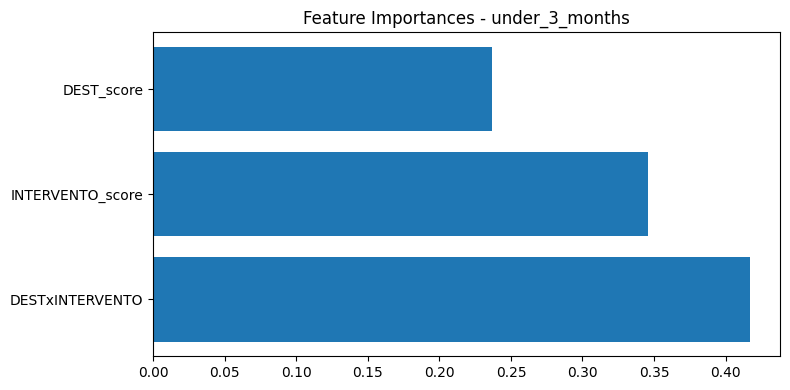


📍 Segment: UNDER_3_MONTHS
R²:   0.694
MAE:  6.76 days
RMSE: 12.53 days


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


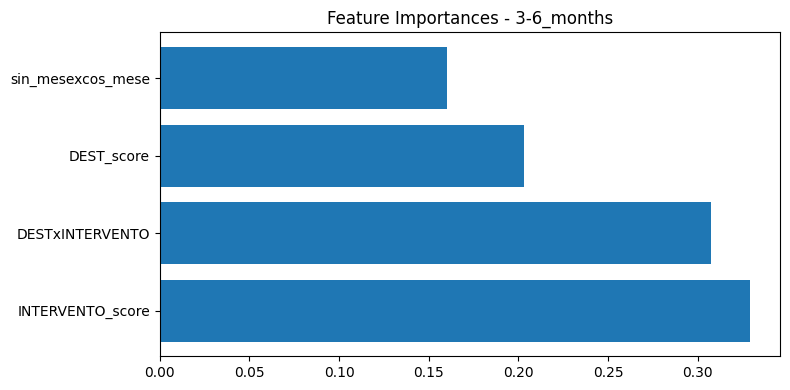


📍 Segment: 3-6_MONTHS
R²:   0.242
MAE:  11.87 days
RMSE: 21.32 days


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


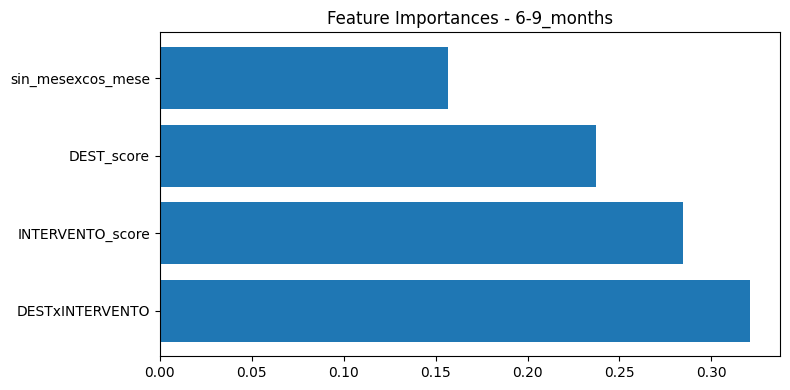


📍 Segment: 6-9_MONTHS
R²:   0.391
MAE:  15.42 days
RMSE: 20.34 days


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


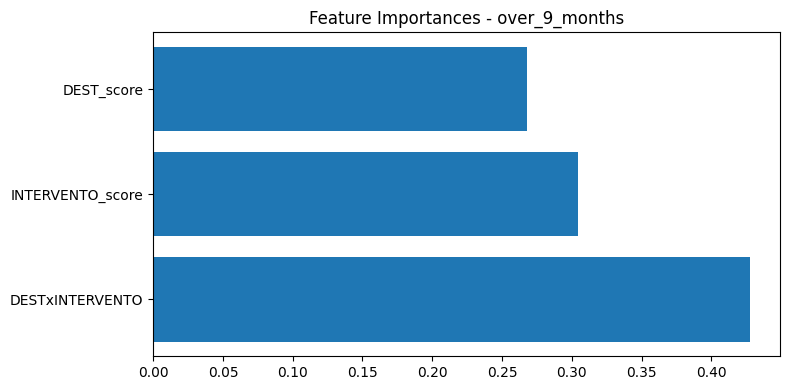


📍 Segment: OVER_9_MONTHS
R²:   0.339
MAE:  47.18 days
RMSE: 75.09 days

📈 Overall Model Performance
R²:   0.902
MAE:  21.59 days
RMSE: 43.42 days


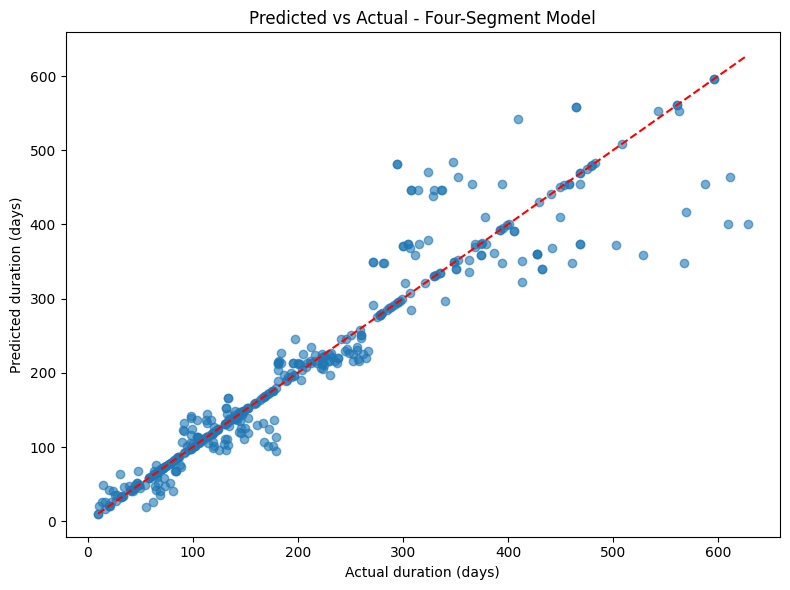


📌 Segment: over_9_months
Selected features: [np.str_('DEST_score'), np.str_('INTERVENTO_score'), np.str_('DESTxINTERVENTO')]
Model parameters: {'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 300, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Available feature columns in df_seg:
['ID_RICHIESTA', 'DURATA_PRATICA', 'RICHIESTA_DATA', 'ESITO_RICHIESTA', 'CON_PRESCRIZIONI', 'DEST_Residenziale', 'DEST_Ufficio', 'DEST_Commerciale', 'DEST_Albergo', 'DEST_Industriale_e_produttiva', 'DEST_Sociali,_ricreative,_culturali_e_religiose', 'DEST_Sanitario', 'DEST_Istruzione', 'DEST_Sportivo', 'DEST_Opere_Urbane', 'DEST_Impianti', 'DEST_Altro', 'NUM_DESTINAZIONI', 'IN_SANATORIA', 'INTERVENTO_Realizzazione_

In [4]:
# 10

# UPLOAD: processed_permit_data_bo.csv

# Load data
file_path = "processed_permit_data_bo.csv"
df = pd.read_csv(file_path)
df.columns = [col.replace(" ", "_") for col in df.columns]

# Compute unified restriction
df["VINCOLATO"] = df[["VINCOLATO_STORICO", "VINCOLATO_IDROGEO"]].sum(axis=1)

# Restrict to permits with duration <= 2 years
df = df[df["DURATA_PRATICA"] <= 730].copy()
df = df.dropna().copy()

# Extract request date
df["RICHIESTA_DATA"] = pd.to_datetime(df["RICHIESTA_DATA"], dayfirst=True, errors='coerce')
df["anno_richiesta"] = df["RICHIESTA_DATA"].dt.year
df["mese_richiesta"] = df["RICHIESTA_DATA"].dt.month

# Combined monthly cyclicality
df["sin_mesexcos_mese"] = np.sin(2 * np.pi * df["mese_richiesta"] / 12) * np.cos(2 * np.pi * df["mese_richiesta"] / 12)

# Macrofeature columns
dest_cols = [col for col in df.columns if col.startswith("DEST_")]
intervento_cols = [col for col in df.columns if col.startswith("INTERVENTO_")]
entita_cols = [col for col in df.columns if col.startswith("ENTITA_")]

# Compute INTERVENTO_score
rf_tmp = RandomForestRegressor(n_estimators=100, random_state=42)
rf_tmp.fit(df[intervento_cols], df["DURATA_PRATICA"])
intervento_importance = rf_tmp.feature_importances_
df["INTERVENTO_score"] = df[intervento_cols].values @ intervento_importance

# Compute DEST_score
rf_tmp_dest = RandomForestRegressor(n_estimators=100, random_state=42)
rf_tmp_dest.fit(df[dest_cols], df["DURATA_PRATICA"])
dest_importance = rf_tmp_dest.feature_importances_
df["DEST_score"] = df[dest_cols].values @ dest_importance

# Targeted oversampling
top_intervento = df["INTERVENTO_score"] >= df["INTERVENTO_score"].quantile(0.75)
top_dest = df["DEST_score"] >= df["DEST_score"].quantile(0.75)
short_cases = df[df["DURATA_PRATICA"] < 90]
long_cases = df[df["DURATA_PRATICA"] > 270]

df_oversampled = pd.concat([
    df,
    df[top_intervento],
    df[top_dest],
    short_cases,
    long_cases
], ignore_index=True)

# Compute ENTITA_score
rf_tmp_entita = RandomForestRegressor(n_estimators=100, random_state=42)
rf_tmp_entita.fit(df_oversampled[entita_cols], df_oversampled["DURATA_PRATICA"])
entita_importance = rf_tmp_entita.feature_importances_
df_oversampled["ENTITA_score"] = df_oversampled[entita_cols].values @ entita_importance

# Geographical clustering
kmeans_exnovo = KMeans(n_clusters=5, random_state=42)
kmeans_res = KMeans(n_clusters=5, random_state=42)
ex_novo_filter = df_oversampled["INTERVENTO_Realizzazione_opere_ex-novo"] == 1
res_filter = df_oversampled["DEST_Residenziale"] == 1
ex_novo_coords = df_oversampled[ex_novo_filter][["lat", "lon"]].dropna()
res_coords = df_oversampled[res_filter][["lat", "lon"]].dropna()
df_oversampled.loc[ex_novo_coords.index, "geo_cluster_INT_EXNOVO"] = kmeans_exnovo.fit_predict(ex_novo_coords)
df_oversampled.loc[res_coords.index, "geo_cluster_DEST_RES"] = kmeans_res.fit_predict(res_coords)
df_oversampled["geo_cluster_INT_EXNOVO"] = df_oversampled["geo_cluster_INT_EXNOVO"].fillna(-1).astype(int)
df_oversampled["geo_cluster_DEST_RES"] = df_oversampled["geo_cluster_DEST_RES"].fillna(-1).astype(int)

# Combined feature
df_oversampled["DESTxINTERVENTO"] = df_oversampled["DEST_score"] * df_oversampled["INTERVENTO_score"]

# Features used
feature_cols = [
    "DEST_score", "INTERVENTO_score", "ENTITA_score", "VINCOLATO",
    "CON_PRESCRIZIONI", "sin_mesexcos_mese",
    "geo_cluster_INT_EXNOVO", "geo_cluster_DEST_RES", "DESTxINTERVENTO"
]

# Segmentation: 4 duration bands
segments = {
    "under_3_months": df_oversampled[df_oversampled["DURATA_PRATICA"] < 90],
    "3-6_months": df_oversampled[(df_oversampled["DURATA_PRATICA"] >= 90) & (df_oversampled["DURATA_PRATICA"] < 180)],
    "6-9_months": df_oversampled[(df_oversampled["DURATA_PRATICA"] >= 180) & (df_oversampled["DURATA_PRATICA"] <= 270)],
    "over_9_months": df_oversampled[df_oversampled["DURATA_PRATICA"] > 270]
}

# Updated training function
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [5, 10, None],
    'min_samples_leaf': [1, 3],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

modelli = {}
selettori = {}
preds_all = []
actual_all = []

for label, df_seg in segments.items():
    if not df_seg.empty:
        X = df_seg[feature_cols]
        y = np.log1p(df_seg["DURATA_PRATICA"])
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='r2', n_jobs=-1)
        grid.fit(X_train, y_train)
        best_rf = grid.best_estimator_

        selector = SelectFromModel(best_rf, threshold="mean", prefit=True)
        X_train_sel = selector.transform(X_train)
        X_test_sel = selector.transform(X_test)
        selected_features = np.array(feature_cols)[selector.get_support()]

        rf_final = RandomForestRegressor(**grid.best_params_, random_state=42)
        rf_final.fit(X_train_sel, y_train)
        y_pred_log = rf_final.predict(X_test_sel)
        y_pred = np.expm1(y_pred_log)
        y_test_real = np.expm1(y_test)

        preds_all.extend(y_pred)
        actual_all.extend(y_test_real)

        # Plot feature importances
        plt.figure(figsize=(8, 4))
        importances = rf_final.feature_importances_
        indices = np.argsort(importances)[::-1]
        plt.barh(selected_features[indices], importances[indices])
        plt.title(f"Feature Importances - {label}")
        plt.tight_layout()
        plt.show()

        print(f"\n📍 Segment: {label.upper()}")
        print(f"R²:   {r2_score(y_test_real, y_pred):.3f}")
        print(f"MAE:  {mean_absolute_error(y_test_real, y_pred):.2f} days")
        print(f"RMSE: {np.sqrt(mean_squared_error(y_test_real, y_pred)):.2f} days")

        modelli[label] = rf_final
        selettori[label] = selector

# Overall evaluation
print("\n📈 Overall Model Performance")
print(f"R²:   {r2_score(actual_all, preds_all):.3f}")
print(f"MAE:  {mean_absolute_error(actual_all, preds_all):.2f} days")
print(f"RMSE: {np.sqrt(mean_squared_error(actual_all, preds_all)):.2f} days")

# Scatter Plot Predicted vs Actual
plt.figure(figsize=(8, 6))
plt.scatter(actual_all, preds_all, alpha=0.6)
plt.plot([min(actual_all), max(actual_all)], [min(actual_all), max(actual_all)], 'r--')
plt.xlabel("Actual duration (days)")
plt.ylabel("Predicted duration (days)")
plt.title("Predicted vs Actual - Four-Segment Model")
plt.tight_layout()
plt.show()

# Save models
joblib.dump(modelli, "modelli_segmentati.pkl")
joblib.dump(selettori, "selettori_segmentati.pkl")

print(f"\n📌 Segment: {label}")
print("Selected features:", list(selected_features))
print("Model parameters:", rf_final.get_params())
print("Available feature columns in df_seg:")
print(list(df_seg.columns))

print("Features used (after selection):")
print(selected_features)
cluster_cols = [col for col in df_seg.columns if col.startswith("geo_cluster_")]
for col in cluster_cols:
    print(f"Cluster distribution for {col}:")
    print(df_seg[col].value_counts().sort_index())


This cell contains the code to create an interpolated heat map of Bologna based on the duration of the request times by location.

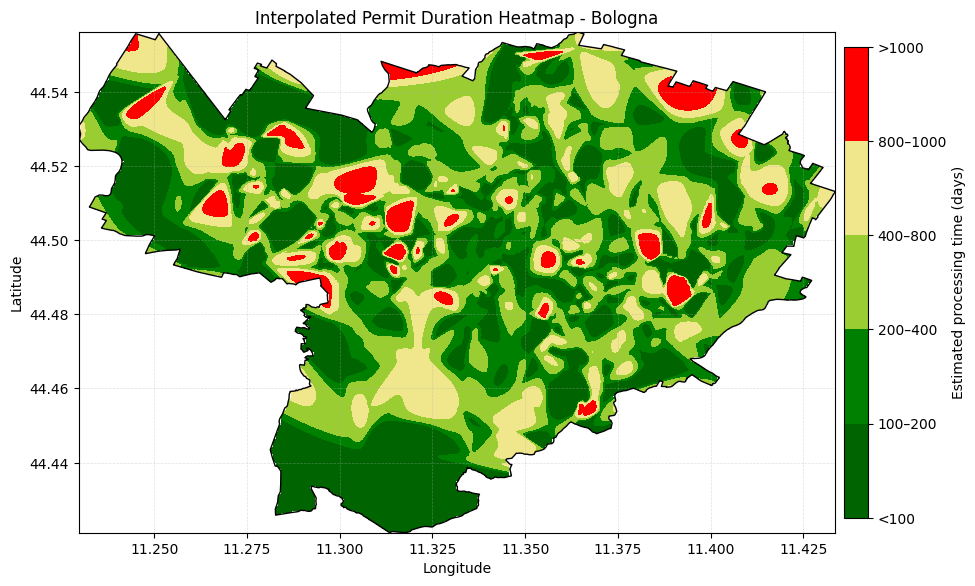

In [2]:
#11

# CREATE a folder named "confini_bologna"
# UPLOAD the contents of the corresponding folder from the repository

# Load shapefile with all municipalities
shapefile_path = "/content/confini_bologna/confini_bologna.shp"  # change if needed
gdf_comuni = gpd.read_file(shapefile_path)

# Filter Bologna only
bologna_gdf = gdf_comuni[gdf_comuni["NOME_C"].str.lower() == "bologna"].to_crs(epsg=4326)

# Load your permit data
df = pd.read_csv("/content/processed_permit_data_bo.csv")

# Drop rows without coordinates
df = df.dropna(subset=["lat", "lon", "DURATA_PRATICA"])

# Prepare data for interpolation
points = df[["lon", "lat"]].values
values = df["DURATA_PRATICA"].values

# Grid definition over Bologna (in EPSG:4326)
xmin, ymin, xmax, ymax = bologna_gdf.total_bounds
grid_x, grid_y = np.mgrid[xmin:xmax:300j, ymin:ymax:300j]

# Interpolation with cubic + fallback to nearest
grid_z_cubic = griddata(points, values, (grid_x, grid_y), method="cubic")
grid_z_nearest = griddata(points, values, (grid_x, grid_y), method="nearest")
grid_z = np.where(np.isnan(grid_z_cubic), grid_z_nearest, grid_z_cubic)

# Clip outliers to max duration (e.g. 1000 days)
grid_z = np.clip(grid_z, 0, 1000)

# Create a GeoDataFrame of grid points
grid_points = np.vstack((grid_x.ravel(), grid_y.ravel())).T
grid_geoms = gpd.GeoSeries([Point(xy) for xy in grid_points], crs="EPSG:4326")
grid_df = gpd.GeoDataFrame(geometry=grid_geoms)
grid_df["value"] = grid_z.ravel()

# Spatial join to filter only points inside Bologna
grid_df = gpd.sjoin(grid_df, bologna_gdf, predicate="within", how="inner")

# Rebuild masked grid
masked_z = np.full_like(grid_z, np.nan)
n_rows, n_cols = grid_z.shape
masked_z_flat = masked_z.ravel()
masked_z_flat[grid_df.index.values] = grid_df["value"].values
masked_z = masked_z_flat.reshape((n_rows, n_cols))

# Define color scale
bounds = [0, 100, 200, 400, 800, 1000]
cmap = ListedColormap(['darkgreen', 'green', 'yellowgreen', 'khaki', 'orange', 'red'])
norm = BoundaryNorm(bounds, cmap.N)

# Use true aspect ratio from geometry bounds
xmin, ymin, xmax, ymax = bologna_gdf.total_bounds
aspect_ratio = (xmax - xmin) / (ymax - ymin)
fig_width = 10
fig_height = fig_width / aspect_ratio

# Plot
fig, ax = plt.subplots(figsize=(fig_width, fig_height))
cf = ax.contourf(grid_x, grid_y, masked_z, levels=bounds, cmap=cmap, norm=norm)
bologna_gdf.boundary.plot(ax=ax, edgecolor='black', linewidth=1)

# Preserve aspect ratio
ax.set_aspect("equal")

# Add transparent dashed gridlines
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.4)

# Colorbar
cbar = plt.colorbar(cf, ax=ax, shrink=0.75, pad=0.01, ticks=bounds)
cbar.ax.set_yticklabels(['<100', '100–200', '200–400', '400–800', '800–1000', '>1000'])
cbar.set_label("Estimated processing time (days)")

plt.title("Interpolated Permit Duration Heatmap - Bologna")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()



With the same logic, the code below plots a month-related polar plot to visualise the busiest month for the PA office of Bologna.

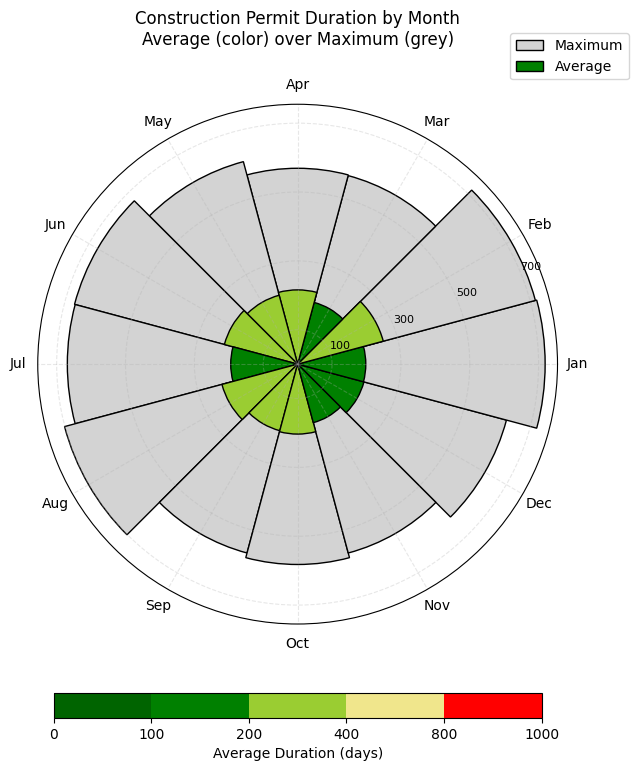

In [75]:
#12

# Monthly average and maximum
df_oversampled["mese_richiesta"] = pd.to_datetime(df_oversampled["RICHIESTA_DATA"]).dt.month
media_per_mese = df_oversampled.groupby("mese_richiesta")["DURATA_PRATICA"].mean()
max_per_mese = df_oversampled.groupby("mese_richiesta")["DURATA_PRATICA"].max()

# December at the top, clockwise order
month_order = [12] + list(range(1, 12))
media_vals = media_per_mese.reindex(month_order).values
max_vals = max_per_mese.reindex(month_order).values

# Angles for the 12 months
theta = np.linspace(0.0, 2 * np.pi, 12, endpoint=False)
theta = np.roll(theta, 1)  # December at the top

# Colormap for average values (same as the heatmap)
bounds = [0, 100, 200, 400, 800, 1000]
cmap = ListedColormap(['darkgreen', 'green', 'yellowgreen', 'khaki', 'orange', 'red'])
norm = BoundaryNorm(bounds, cmap.N)
colors = cmap(norm(media_vals))

# Polar plot
fig, ax = plt.subplots(figsize=(9, 9), subplot_kw={'projection': 'polar'})

# Base bar = maximum (gray)
ax.bar(theta, max_vals, width=2 * np.pi / 12, color='lightgrey', edgecolor='black', label='Maximum')

# Overlapping bar = average (colored)
ax.bar(theta, media_vals, width=2 * np.pi / 12, color=colors, edgecolor='black', label='Average')

# Month labels (in English)
month_labels = ['Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov']
ax.set_xticks(theta)
ax.set_xticklabels(month_labels)

# Concentric circle labels (duration)
r_ticks = [100, 300, 500, 700]
ax.set_yticks(r_ticks)
ax.set_yticklabels([str(r) for r in r_ticks], fontsize=9)
ax.tick_params(axis='y', labelsize=8, pad=5)

# Colorbar (for average)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.1, shrink=0.7, orientation='horizontal')
cbar.set_label("Average Duration (days)")

# Final styling
ax.set_title("Construction Permit Duration by Month\nAverage (color) over Maximum (grey)", va='bottom', pad=40)
ax.grid(True, linestyle='--', alpha=0.3)
ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1.15))

plt.show()


## Feature importance

,DEST_feature,weight_importance,activation_average,average_contribution
4,DEST_Industriale e produttiva,0.216871,0.181303,0.039319
0,DEST_Residenziale,0.166718,0.360718,0.060138
1,DEST_Ufficio,0.108553,0.075543,0.008200
10,DEST_Impianti,0.097778,0.128423,0.012557
9,DEST_Opere_Urbane,0.093351,0.196412,0.018335
2,DEST_Commerciale,0.084074,0.111426,0.009368
5,"DEST_Sociali, ricreative, culturali e religiose",0.063159,0.070822,0.004473
6,DEST_Sanitario,0.062426,0.030217,0.001886
3,DEST_Albergo,0.035282,0.020774,0.000733
7,DEST_Istruzione,0.033278,0.013220,0.000440


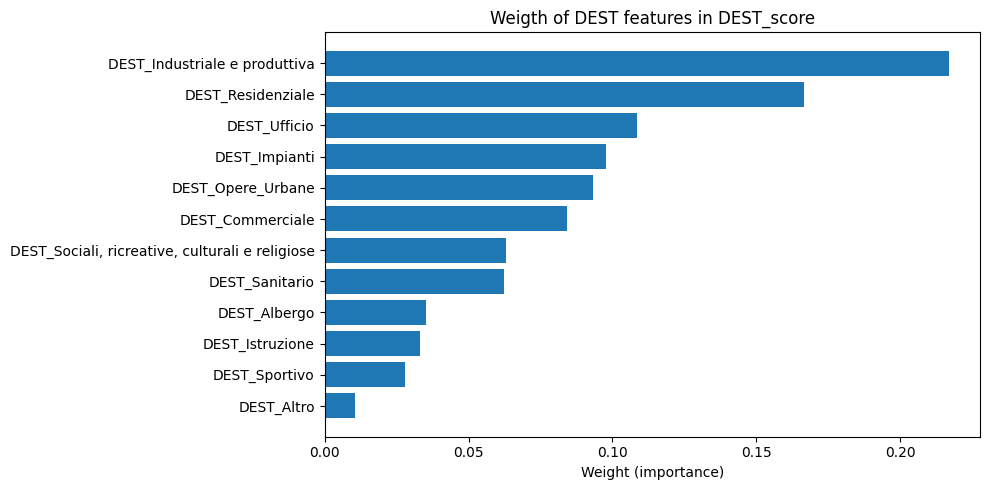

In [76]:
#13

# One-hot DEST_ columns
dest_cols = [col for col in df.columns if col.startswith("DEST_") and not col.endswith("_score")]

# Train RandomForestRegressor to obtain the importance of each DEST_ in predicting REQUEST_TIME
rf_dest = RandomForestRegressor(n_estimators=100, random_state=42)
rf_dest.fit(df[dest_cols], df["DURATA_PRATICA"])

# DEST_ weight table construction
importanze_dest = rf_dest.feature_importances_
df_pesi_dest = pd.DataFrame({
    'DEST_feature': dest_cols,
    'weight_importance': importanze_dest,
    'activation_average': df[dest_cols].mean().values
})
df_pesi_dest['average_contribution'] = df_pesi_dest['weight_importance'] * df_pesi_dest['activation_average']
df_pesi_dest = df_pesi_dest.sort_values(by='weight_importance', ascending=False)

# Display table
display(df_pesi_dest)

# Plot
plt.figure(figsize=(10, 5))
plt.barh(df_pesi_dest['DEST_feature'], df_pesi_dest['weight_importance'])
plt.xlabel("Weight (importance)")
plt.title("Weigth of DEST features in DEST_score")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


,INTERVENTO_feature,weight_importance,activation_average,average_contribution
0,INTERVENTO_Realizzazione_opere_ex-novo,0.161084,0.625118,0.100696
4,INTERVENTO_Ristrutturazione,0.130529,0.248347,0.032416
2,INTERVENTO_Demolizione,0.128797,0.208687,0.026878
7,INTERVENTO_Variante_a_progetto,0.125934,0.226629,0.028540
3,INTERVENTO_Ricostruzione,0.113949,0.135033,0.015387
1,INTERVENTO_Ampliamento,0.113803,0.241737,0.027510
6,INTERVENTO_Cambio_Uso,0.111929,0.101983,0.011415
5,INTERVENTO_Installazione,0.104818,0.039660,0.004157
8,INTERVENTO_Altro,0.009159,0.031161,0.000285


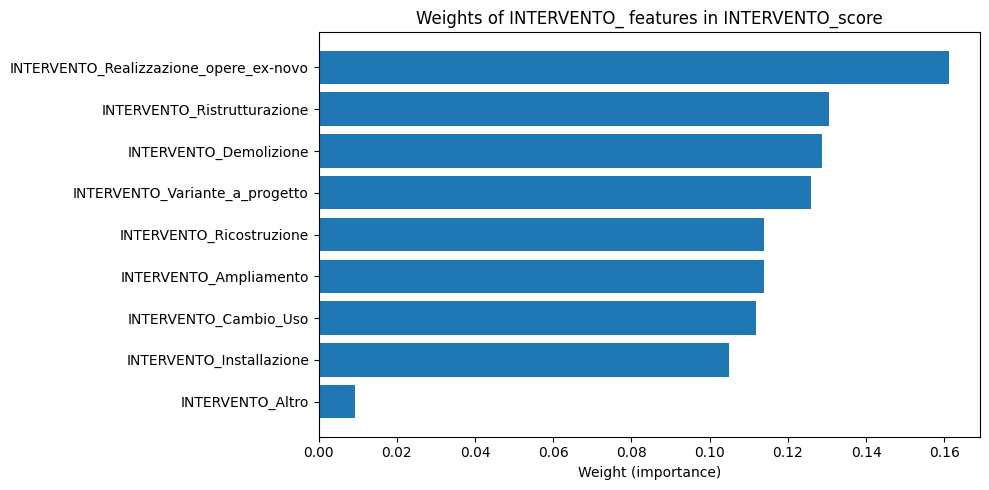

In [77]:
#14

# One-hot INTERVENTO_ columns
intervento_cols = [col for col in df.columns if col.startswith("INTERVENTO_") and not col.endswith("_score")]

# Train RandomForestRegressor to obtain the weights of INTERVENTO_ in predicting REQUEST_TIME
rf_intervento = RandomForestRegressor(n_estimators=100, random_state=42)
rf_intervento.fit(df[intervento_cols], df["DURATA_PRATICA"])

# INTERVENTO_ weight table construction
importanze_intervento = rf_intervento.feature_importances_
df_pesi_intervento = pd.DataFrame({
    'INTERVENTO_feature': intervento_cols,
    'weight_importance': importanze_intervento,
    'activation_average': df[intervento_cols].mean().values
})
df_pesi_intervento['average_contribution'] = df_pesi_intervento['weight_importance'] * df_pesi_intervento['activation_average']
df_pesi_intervento = df_pesi_intervento.sort_values(by='weight_importance', ascending=False)

# Display table
display(df_pesi_intervento)

# Plot
plt.figure(figsize=(10, 5))
plt.barh(df_pesi_intervento['INTERVENTO_feature'], df_pesi_intervento['weight_importance'])
plt.xlabel("Weight (importance)")
plt.title("Weights of INTERVENTO_ features in INTERVENTO_score")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## User interface

In [78]:
#15

# Recreate base dataset (without oversampling)
df_filtered = df.copy()
df_filtered["VINCOLATO"] = df_filtered[["VINCOLATO_STORICO", "VINCOLATO_IDROGEO"]].sum(axis=1)

# Check correct column names
ex_novo_col = [col for col in df_filtered.columns if col.startswith("INTERVENTO_") and "Realizzazione" in col][0]
res_col = [col for col in df_filtered.columns if col.startswith("DEST_") and "Residenziale" in col][0]

# Select coordinates for clustering
ex_novo_coords = df_filtered[df_filtered[ex_novo_col] == 1][["lat", "lon"]].dropna()
res_coords = df_filtered[df_filtered[res_col] == 1][["lat", "lon"]].dropna()

# Fit KMeans
kmeans_exnovo = KMeans(n_clusters=5, random_state=42)
kmeans_res = KMeans(n_clusters=5, random_state=42)

kmeans_exnovo.fit(ex_novo_coords)
kmeans_res.fit(res_coords)

print("Geographic clusters successfully recreated.")

# Load models and selectors
modelli = joblib.load("modelli_segmentati.pkl")
selettori = joblib.load("selettori_segmentati.pkl")

# Macro-feature columns
dest_cols = [col for col in df.columns if col.startswith("DEST_")]
intervento_cols = [col for col in df.columns if col.startswith("INTERVENTO_")]
entita_cols = [col for col in df.columns if col.startswith("ENTITA_")]

# Feature importances
def weighted_macro_feature(df, cols, target):
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(df[cols], df[target])
    return rf.feature_importances_

dest_importances = weighted_macro_feature(df, dest_cols, "DURATA_PRATICA")
intervento_importances = weighted_macro_feature(df, intervento_cols, "DURATA_PRATICA")
entita_importances = weighted_macro_feature(df, entita_cols, "DURATA_PRATICA")

# Widget checkboxes
dest_checkboxes = [widgets.Checkbox(description=col.replace("DEST_", ""), value=False) for col in dest_cols]
intervento_checkboxes = [widgets.Checkbox(description=col.replace("INTERVENTO_", ""), value=False) for col in intervento_cols]
entita_checkboxes = [widgets.Checkbox(description=col.replace("ENTITA_", ""), value=False) for col in entita_cols]

# Additional parameters
vincolo = widgets.Checkbox(description='Vincolato', value=False)
mese = widgets.BoundedIntText(description='Mese richiesta', min=1, max=12, value=5)
lat_input = widgets.FloatText(description="Lat", value=44.5)
lon_input = widgets.FloatText(description="Lon", value=11.3)

# Interface layout
display(
    widgets.HBox([
        widgets.VBox([widgets.HTML("<b>DEST:</b>")] + dest_checkboxes),
        widgets.VBox([widgets.HTML("<b>INTERVENTO:</b>")] + intervento_checkboxes),
        widgets.VBox([widgets.HTML("<b>ENTITA:</b>")] + entita_checkboxes),
        widgets.VBox([vincolo, mese, lat_input, lon_input])
    ])
)

# Output and button
output = widgets.Output()
btn = widgets.Button(description="Estimate permit duration")

def predici_durata_interattivo(b):
    with output:
        clear_output()

        # Collect selected values
        d_vals = np.array([cb.value for cb in dest_checkboxes], dtype=float)
        i_vals = np.array([cb.value for cb in intervento_checkboxes], dtype=float)
        e_vals = np.array([cb.value for cb in entita_checkboxes], dtype=float)

        d_score = np.dot(d_vals, dest_importances)
        i_score = np.dot(i_vals, intervento_importances)
        e_score = np.dot(e_vals, entita_importances)
        sin_mesexcos = np.sin(2 * np.pi * mese.value / 12) * np.cos(2 * np.pi * mese.value / 12)

        # Compute geographic clusters dynamically
        coords = np.array([[lat_input.value, lon_input.value]])
        geo_cluster_int = int(kmeans_exnovo.predict(coords)[0]) if hasattr(kmeans_exnovo, "cluster_centers_") else -1
        geo_cluster_dest = int(kmeans_res.predict(coords)[0]) if hasattr(kmeans_res, "cluster_centers_") else -1

        # Build input
        x_input = pd.DataFrame([{
            "DEST_score": d_score,
            "INTERVENTO_score": i_score,
            "ENTITA_score": e_score,
            "VINCOLATO": int(vincolo.value),
            "CON_PRESCRIZIONI": 0,  # Forced
            "sin_mesexcos_mese": sin_mesexcos,
            "geo_cluster_INT_EXNOVO": geo_cluster_int,
            "geo_cluster_DEST_RES": geo_cluster_dest,
            "DESTxINTERVENTO": d_score * i_score
        }])

        # Segmentation
        if i_score < 0.3 and d_score < 0.3:
            segmento = "molto_breve"
        elif i_score < 0.55:
            segmento = "breve_medio"
        elif i_score < 0.75:
            segmento = "medio_lungo"
        else:
            segmento = "lungo"

        modello = modelli[segmento]
        selettore = selettori[segmento]
        x_sel = selettore.transform(x_input)
        durata_log = modello.predict(x_sel)[0]
        durata_predetta = np.expm1(durata_log)

        print(f"\nSelected segment: {segmento}")
        print(f"Estimated permit duration: {durata_predetta:.1f} days")
        print(f"Cluster INT_EXNOVO: {geo_cluster_int} — Cluster DEST_RES: {geo_cluster_dest}")

btn.on_click(predici_durata_interattivo)
display(btn, output)


Geographic clusters successfully recreated.


Button(description='Estimate permit duration', style=ButtonStyle())

Output()

# **Model 2**

## Model creation

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

>>> Best classification parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Automatically selected macro-features (classification): ['DEST_score_c' 'INTERVENTO_score_c' 'CON_PRESCRIZIONI' 'NUM_DESTINAZIONI']


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(



--- OUTCOME CLASSIFICATION (weighted, selected macro-features, oversampling) ---
Accuracy: 0.8873239436619719
Classification report:
                              precision    recall  f1-score   support

                     Negato       0.67      1.00      0.81        29
      Richiesta di varianti       0.77      0.95      0.85        60
                 Rilasciato       1.00      0.71      0.83        95
Rilasciato con prescrizioni       0.99      0.99      0.99       100

                   accuracy                           0.89       284
                  macro avg       0.86      0.91      0.87       284
               weighted avg       0.91      0.89      0.89       284



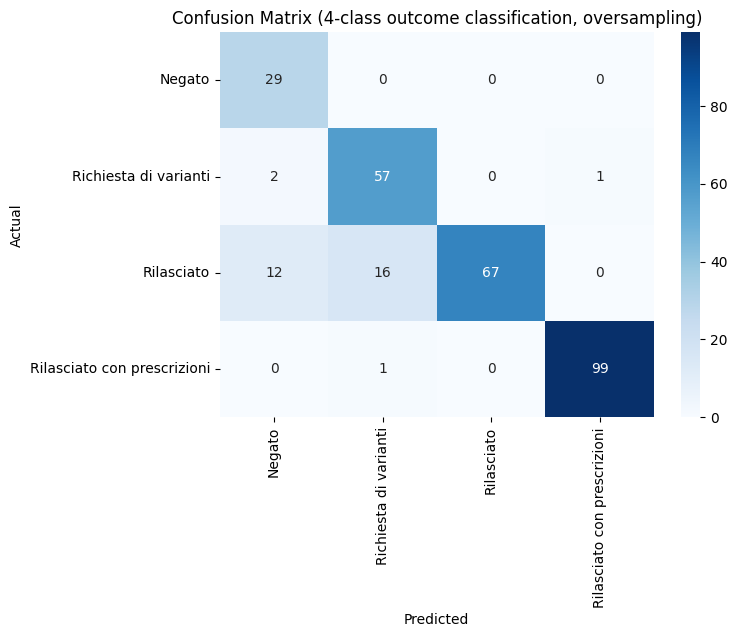

<ipython-input-6-17f05e7ef855>:126: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances_c[indices_c], y=selected_features_c[indices_c], palette="viridis")


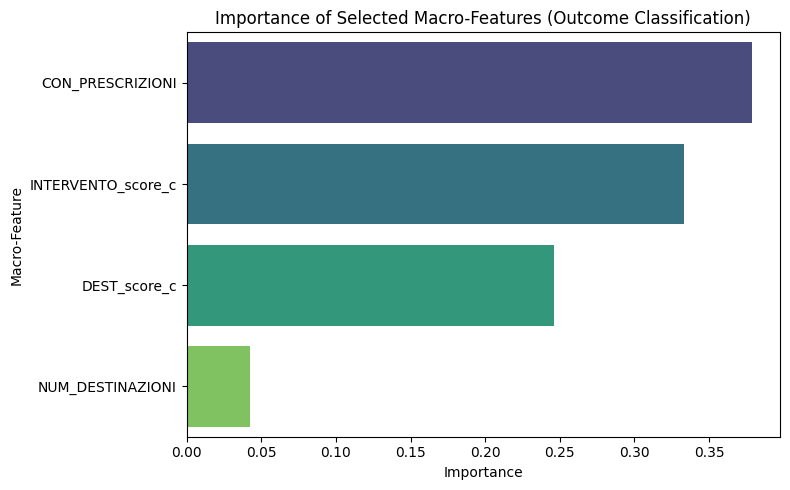

Model saved as 'modello_esito_permesso.pkl'


In [6]:
# 16

# UPLOAD: processed_permit_data.csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def make_safe_name(name):
    import re
    return re.sub(r'[^A-Za-z0-9]+', '_', name)

df = pd.read_csv('processed_permit_data_bo.csv')
df.columns = [make_safe_name(col) for col in df.columns]

dest_cols = [col for col in df.columns if col.startswith('DEST_')]
intervento_cols = [col for col in df.columns if col.startswith('INTERVENTO_')]
entita_cols = [col for col in df.columns if col.startswith('ENTITA_')]

def weighted_macro_feature(df, cols, target):
    rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    rf.fit(df[cols], df[target])
    importance = rf.feature_importances_
    return df[cols].values @ importance, importance

# Definition of the 4 outcome classes
def esito_4classi(row):
    if row['ESITO_RICHIESTA'] == 'Positiv' and row['CON_PRESCRIZIONI'] == 0:
        return 'Rilasciato'
    elif row['ESITO_RICHIESTA'] == 'Positiv' and row['CON_PRESCRIZIONI'] == 1:
        return 'Rilasciato con prescrizioni'
    elif row['ESITO_RICHIESTA'] == 'Neutro':
        return 'Richiesta di varianti'
    elif row['ESITO_RICHIESTA'] == 'Negativ':
        return 'Negato'
    else:
        return 'Altro'
df['ESITO_4CLASSI'] = df.apply(esito_4classi, axis=1)
df = df[df['ESITO_4CLASSI'] != 'Altro']

# --- MANUAL OVERSAMPLING OF MINORITY CLASSES ---
df_bal = df.copy()
neg = df_bal[df_bal['ESITO_4CLASSI'] == 'Negato']
neu = df_bal[df_bal['ESITO_4CLASSI'] == 'Richiesta di varianti']
df_bal = pd.concat([
    df_bal,
    pd.concat([neg]*10, ignore_index=True),
    pd.concat([neu]*3, ignore_index=True)
], ignore_index=True)

# Create temporary column with numeric class codes for macro-feature weighting
df_bal['ESITO_4CLASSI_CODE'] = df_bal['ESITO_4CLASSI'].astype('category').cat.codes

df_bal['DEST_score_c'], _ = weighted_macro_feature(df_bal, dest_cols, 'ESITO_4CLASSI_CODE')
df_bal['INTERVENTO_score_c'], _ = weighted_macro_feature(df_bal, intervento_cols, 'ESITO_4CLASSI_CODE')
df_bal['ENTITA_score_c'], _ = weighted_macro_feature(df_bal, entita_cols, 'ESITO_4CLASSI_CODE')
df_bal['VINCOLATO'] = df_bal[['VINCOLATO_STORICO', 'VINCOLATO_IDROGEO']].max(axis=1)

# Remove temporary column
df_bal.drop(columns=['ESITO_4CLASSI_CODE'], inplace=True)

feature_cols_c = ['DEST_score_c', 'INTERVENTO_score_c', 'ENTITA_score_c', 'VINCOLATO', 'IN_SANATORIA', 'CON_PRESCRIZIONI', 'NUM_DESTINAZIONI']
Xc = df_bal[feature_cols_c]
yc = df_bal['ESITO_4CLASSI']

# Train/test split
Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    Xc, yc, test_size=0.2, random_state=42, stratify=yc
)

# GridSearchCV for classification
param_grid_c = {
    'n_estimators': [100, 300],
    'max_depth': [5, 10, None],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}
grid_c = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid_c,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
grid_c.fit(Xc_train, yc_train)
clf = grid_c.best_estimator_
print("\n>>> Best classification parameters:", grid_c.best_params_)

# Automatic selection of macro-features
selector_c = SelectFromModel(clf, threshold="median", prefit=True)
Xc_train_sel = selector_c.transform(Xc_train)
Xc_test_sel = selector_c.transform(Xc_test)
selected_features_c = np.array(feature_cols_c)[selector_c.get_support()]
print("\nAutomatically selected macro-features (classification):", selected_features_c)

# Train new model only on selected macro-features
clf_sel = RandomForestClassifier(**grid_c.best_params_, random_state=42, class_weight='balanced')
clf_sel.fit(Xc_train_sel, yc_train)
yc_pred = clf_sel.predict(Xc_test_sel)
yc_proba = clf_sel.predict_proba(Xc_test_sel)

# Performance
print("\n--- OUTCOME CLASSIFICATION (weighted, selected macro-features, oversampling) ---")
print("Accuracy:", accuracy_score(yc_test, yc_pred))
print("Classification report:\n", classification_report(yc_test, yc_pred))
cm = confusion_matrix(yc_test, yc_pred, labels=clf_sel.classes_)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf_sel.classes_, yticklabels=clf_sel.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (4-class outcome classification, oversampling)")
plt.show()

# Importance of selected macro-features
importances_c = clf_sel.feature_importances_
plt.figure(figsize=(8,5))
indices_c = np.argsort(importances_c)[::-1]
sns.barplot(x=importances_c[indices_c], y=selected_features_c[indices_c], palette="viridis")
plt.title("Importance of Selected Macro-Features (Outcome Classification)")
plt.xlabel("Importance")
plt.ylabel("Macro-Feature")
plt.tight_layout()
plt.show()

# Save final model
joblib.dump(clf_sel, 'modello_esito_permesso.pkl')
print("Model saved as 'modello_esito_permesso.pkl'")


## Feature importance

,DEST_feature,weight_importance,activation_average,average_contribution
2,DEST_Commerciale,0.215099,0.339210,0.072964
10,DEST_Impianti,0.158041,0.068406,0.010811
0,DEST_Residenziale,0.123055,0.133992,0.016488
4,DEST_Industriale_e_produttiva,0.122163,0.017630,0.002154
5,DEST_Sociali_ricreative_culturali_e_religiose,0.079945,0.177010,0.014151
9,DEST_Opere_Urbane,0.077643,0.066291,0.005147
1,DEST_Ufficio,0.066258,0.026798,0.001776
8,DEST_Sportivo,0.045303,0.009873,0.000447
11,DEST_Altro,0.045101,0.012694,0.000573
6,DEST_Sanitario,0.028885,0.183357,0.005296


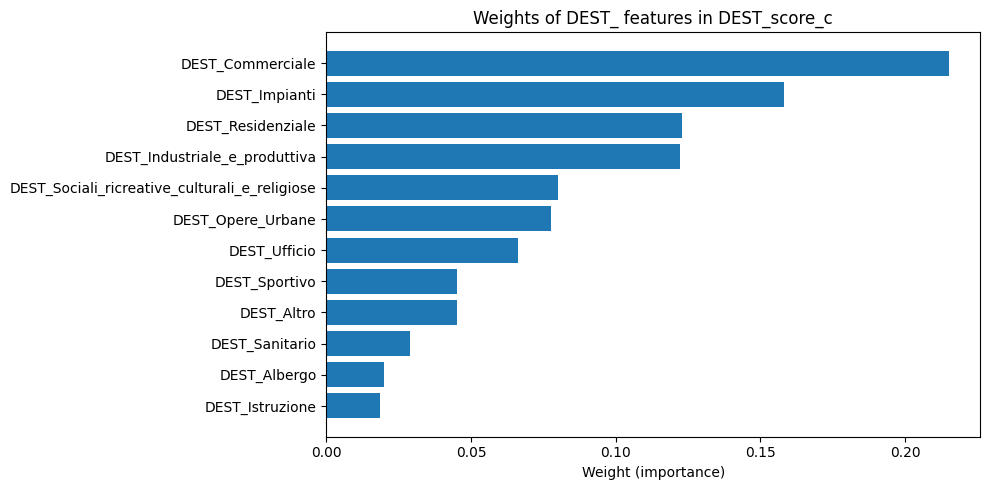

In [85]:
#17

# One-hot DEST columns
dest_cols = [col for col in df_bal.columns if col.startswith("DEST_") and not col.endswith("_score_c")]

# Recode outcome to calculate weights
df_tmp = df_bal.copy()
df_tmp['ESITO_CODE'] = df_tmp['ESITO_4CLASSI'].astype('category').cat.codes

# Train RF to calculate feature importance
rf_dest = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_dest.fit(df_tmp[dest_cols], df_tmp['ESITO_CODE'])

# Get weights of DEST features
importanze_dest = rf_dest.feature_importances_
df_pesi_dest = pd.DataFrame({
    'DEST_feature': dest_cols,
    'weight_importance': importanze_dest
}).sort_values(by='weight_importance', ascending=False)

# Evaluate average contribution of each feature to DEST_score_c
df_pesi_dest['activation_average'] = df_bal[dest_cols].mean().values
df_pesi_dest['average_contribution'] = df_pesi_dest['weight_importance'] * df_pesi_dest['activation_average']

# Display table
display(df_pesi_dest)

# Plot
plt.figure(figsize=(10, 5))
plt.barh(df_pesi_dest['DEST_feature'], df_pesi_dest['weight_importance'])
plt.xlabel("Weight (importance)")
plt.title("Weights of DEST_ features in DEST_score_c")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



,INTERVENTO_feature,weight_importance,activation_average,average_contribution
0,INTERVENTO_Realizzazione_opere_ex_novo,0.169390,0.638928,0.108228
4,INTERVENTO_Ristrutturazione,0.144190,0.220028,0.031726
3,INTERVENTO_Ricostruzione,0.139768,0.229901,0.032133
1,INTERVENTO_Ampliamento,0.128309,0.162200,0.020812
5,INTERVENTO_Installazione,0.119027,0.251058,0.029883
7,INTERVENTO_Variante_a_progetto,0.113327,0.062059,0.007033
2,INTERVENTO_Demolizione,0.091822,0.092384,0.008483
6,INTERVENTO_Cambio_Uso,0.085058,0.188999,0.016076
8,INTERVENTO_Altro,0.009110,0.025388,0.000231


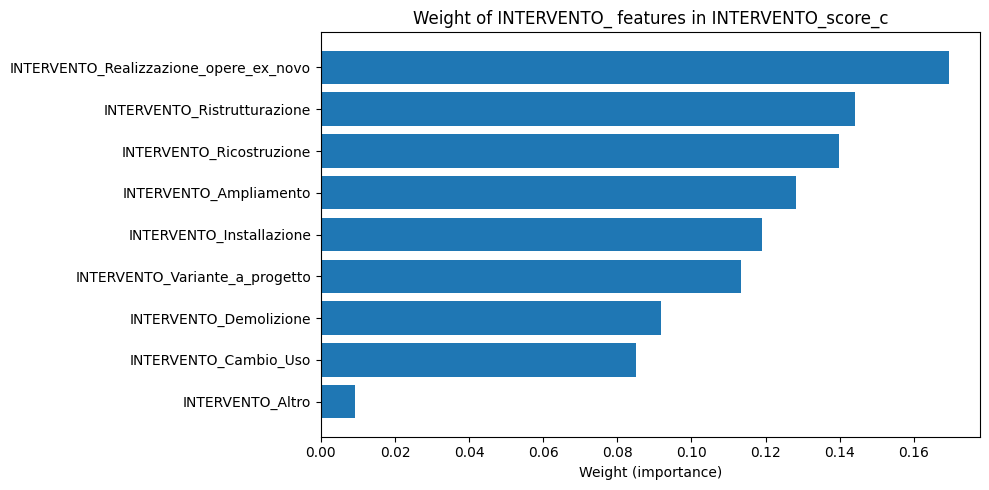

In [86]:
#18

# One-hot INTERVENTO columns
intervento_cols = [col for col in df_bal.columns if col.startswith("INTERVENTO_") and not col.endswith("_score_c")]

# Recode outcome to calculate weights
df_tmp = df_bal.copy()
df_tmp['ESITO_CODE'] = df_tmp['ESITO_4CLASSI'].astype('category').cat.codes

# Train RF to calculate feature importance
rf_intervento = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_intervento.fit(df_tmp[intervento_cols], df_tmp['ESITO_CODE'])

# Get weights of INTERVENTO features
importanze_intervento = rf_intervento.feature_importances_
df_pesi_intervento = pd.DataFrame({
    'INTERVENTO_feature': intervento_cols,
    'weight_importance': importanze_intervento
}).sort_values(by='weight_importance', ascending=False)

# Evaluate average contribution of each feature to INTERVENTO_score_c
df_pesi_intervento['activation_average'] = df_bal[intervento_cols].mean().values
df_pesi_intervento['average_contribution'] = df_pesi_intervento['weight_importance'] * df_pesi_intervento['activation_average']

# Display table
display(df_pesi_intervento)

# Plot graph
plt.figure(figsize=(10, 5))
plt.barh(df_pesi_intervento['INTERVENTO_feature'], df_pesi_intervento['weight_importance'])
plt.xlabel("Weight (importance)")
plt.title("Weight of INTERVENTO_ features in INTERVENTO_score_c")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## User interface

In [83]:
#19

import ipywidgets as widgets
from IPython.display import display, clear_output

# Ensure consistent preprocessing with the training phase
df_bal['ESITO_4CLASSI_CODE'] = df_bal['ESITO_4CLASSI'].astype('category').cat.codes

# Compute and return feature importances for macro-feature weighting
def weighted_macro_feature(df, cols, target):
    rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    rf.fit(df[cols], df[target])
    importance = rf.feature_importances_
    return importance

# Calculate feature importances for each macro-feature group
dest_importances = weighted_macro_feature(df_bal, dest_cols, 'ESITO_4CLASSI_CODE')
intervento_importances = weighted_macro_feature(df_bal, intervento_cols, 'ESITO_4CLASSI_CODE')
entita_importances = weighted_macro_feature(df_bal, entita_cols, 'ESITO_4CLASSI_CODE')

# Destination type widgets
dest_options = [col.replace('DEST_', '') for col in dest_cols]
dest_checkboxes = [widgets.Checkbox(description=dest, value=False) for dest in dest_options]
dest_box = widgets.VBox([widgets.HTML("<b>Building use types:</b>")] + dest_checkboxes)

# Intervention type widgets
intervento_options = [col.replace('INTERVENTO_', '') for col in intervento_cols]
intervento_checkboxes = [widgets.Checkbox(description=int_type, value=False) for int_type in intervento_options]
intervento_box = widgets.VBox([widgets.HTML("<b>Type of intervention:</b>")] + intervento_checkboxes)

# Intervention scale widgets
entita_options = [col.replace('ENTITA_', '') for col in entita_cols]
entita_checkboxes = [widgets.Checkbox(description=ent, value=False) for ent in entita_options]
entita_box = widgets.VBox([widgets.HTML("<b>Scale of intervention:</b>")] + entita_checkboxes)

# Other parameters (excluding CON_PRESCRIZIONI)
vincolo = widgets.Checkbox(description='Protected or constrained area', value=False)
sanatoria = widgets.Checkbox(description='Amnesty case (sanatoria)', value=False)

altri_params = widgets.VBox([
    widgets.HTML("<b>Other parameters:</b>"),
    vincolo,
    sanatoria
])

# Full interface layout
layout = widgets.HBox([dest_box, intervento_box, entita_box, altri_params])

# Function to compute prediction probabilities and display the result
def show_prediction(b):
    # Collect user-selected values
    dest_values = np.array([cb.value for cb in dest_checkboxes], dtype=float)
    intervento_values = np.array([cb.value for cb in intervento_checkboxes], dtype=float)
    entita_values = np.array([cb.value for cb in entita_checkboxes], dtype=float)

    # Compute weighted scores
    dest_score = np.dot(dest_values, dest_importances)
    intervento_score = np.dot(intervento_values, intervento_importances)
    entita_score = np.dot(entita_values, entita_importances)

    # Automatically compute NUM_DESTINAZIONI based on number of selected DEST_ checkboxes
    num_dest = int(dest_values.sum())

    # Input dictionary
    input_dict = {
        'DEST_score_c': dest_score,
        'INTERVENTO_score_c': intervento_score,
        'ENTITA_score_c': entita_score,
        'VINCOLATO': int(vincolo.value),
        'IN_SANATORIA': int(sanatoria.value),
        'NUM_DESTINAZIONI': 1,
        'CON_PRESCRIZIONI': 0
    }

    # Keep only the features used in the model
    Xc_user = pd.DataFrame([{k: v for k, v in input_dict.items() if k in selected_features_c}])

    # Normalize inputs as done in training (if needed)
    for col in Xc_user.columns:
        if col in df_bal.columns:
            mean_val = df_bal[col].mean()
            std_val = df_bal[col].std()
            if std_val > 0:
                Xc_user[col] = (Xc_user[col] - mean_val) / std_val

    # Predict probabilities and plot result
    probs = clf_sel.predict_proba(Xc_user)[0]
    plt.figure(figsize=(10,6))
    bars = plt.bar(clf_sel.classes_, probs)
    plt.title('Estimated outcome probabilities')
    plt.xlabel('Outcome')
    plt.ylabel('Probability')

    # Add probability percentage above each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.1%}',
                 ha='center', va='bottom')

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Show predicted outcome
    pred = clf_sel.predict(Xc_user)[0]
    print(f"\nMost probable outcome: {pred}")
    print("\nNote: Prescription requirements will be determined during the review process.")

# Predict button setup
predict_btn = widgets.Button(description='Estimate Outcome Probabilities')
predict_btn.on_click(show_prediction)

# Display the interface
display(layout)
display(predict_btn)


Button(description='Estimate Outcome Probabilities', style=ButtonStyle())

📊 Top 4 feature per esito 'Negato':
INTERVENTO_score_c: 0.2572
DEST_score_c: 0.2142
CON_PRESCRIZIONI: 0.2124
NUM_DESTINAZIONI: 0.1023
Distribuzione target 'Negato':
TARGET_NEGATO
0    1275
1     143
Name: count, dtype: int64
Shape output predict_proba: (1418, 2)
Classi previste dal modello: [0 1]


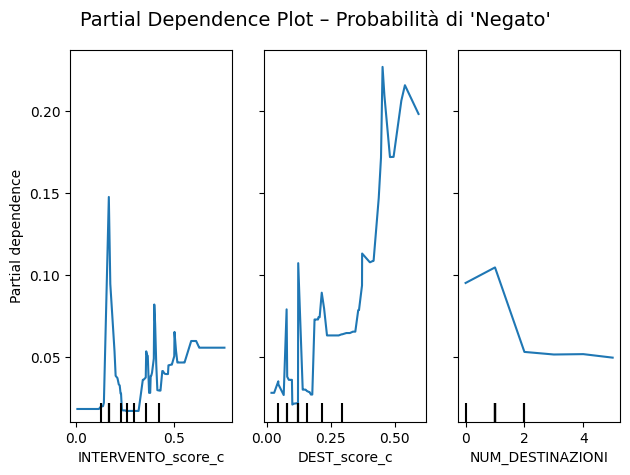

In [ ]:
#BONUS
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Supponendo che tu abbia già caricato il tuo dataset bilanciato:
# df_bal = ...

# Definisci il target binario "Negato" vs tutti gli altri
df_bal['TARGET_NEGATO'] = (df_bal['ESITO_4CLASSI'] == 'Negato').astype(int)

# Usa solo le feature selezionate
feature_cols = ['DEST_score_c', 'INTERVENTO_score_c', 'ENTITA_score_c', 'VINCOLATO', 'IN_SANATORIA', 'CON_PRESCRIZIONI', 'NUM_DESTINAZIONI']
X_bin = df_bal[feature_cols]
y_bin = df_bal['TARGET_NEGATO']

# Allena un modello Random Forest binario
clf_bin = RandomForestClassifier(random_state=42, class_weight='balanced')
clf_bin.fit(X_bin, y_bin)

# Trova le 3–4 feature più importanti
importances = clf_bin.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
top_features = [feature_cols[i] for i in sorted_idx[:4]]

print("📊 Top 4 feature per esito 'Negato':")
for i in range(4):
    print(f"{top_features[i]}: {importances[sorted_idx[i]]:.4f}")

print("Distribuzione target 'Negato':")
print(df_bal['TARGET_NEGATO'].value_counts())

# Verifica che il modello restituisca due colonne (una per ciascuna classe binaria)
proba = clf_bin.predict_proba(X_bin)
print("Shape output predict_proba:", proba.shape)
print("Classi previste dal modello:", clf_bin.classes_)
# Rimuovi la feature binaria dal grafico PDP
top_features_filtered = [f for f in top_features if f != 'CON_PRESCRIZIONI']

from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

PartialDependenceDisplay.from_estimator(
    clf_bin,
    X_bin,
    features=top_features_filtered,
    response_method='predict_proba',
    target=1
)

plt.suptitle("Partial Dependence Plot – Probabilità di 'Negato'", fontsize=14)
plt.tight_layout()
plt.show()



